# Art Classification


# Introduction

This project aims at developing a deep neural network model to classify portraits according to their style. The model is trained on the WikiArt Faces.
We are going to deal with an **image classification task**.

## Packages

In [ ]:
import torch
import os 
import pandas as pd 
import numpy as np 
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import plotly.colors
import plotly.graph_objects as go
import plotly.subplots

import seaborn as sns
import matplotlib.pyplot as plt
! pip install torchmetrics
import torchmetrics
from torchmetrics import ConfusionMatrix as CM

from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

import torch.nn.functional as F

! pip install torchmetrics
import torchmetrics

from sklearn.metrics import confusion_matrix,f1_score,classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler, ConcatDataset



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

In [ ]:
from sklearn.metrics import classification_report

## The dataset
The original WikiArt dataset [(link to the original Kaggle dataset)](https://www.kaggle.com/datasets/jlbaker361/wikiart-faces//) is organised in $26$ style cathegories, but some of them have too few observations to be useful for our task. 
Therefore, we decided to construct a balanced dataset, selecting $10$ artistic styles and taking $500$ observations each.
Hence our modified dataset contains $5000$ portraits, each  classified accordingly to one of the following styles: **art-noveau, baroque, expressionism, high-renaissance, impressionism, mannerism, realism, rococo, romanticism, symbolism**.



The following shows some preliminary operations that we have done before dealing with the image classification task.

Connecting to Google Drive

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Below an exemple of an image:

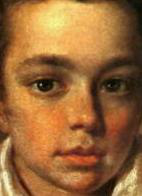

In [ ]:
Image.open("/image_path/1000_romanticism.jpg")


Import the `csv` file containing images' names and the corresponding labels.

The `csv` file is available in the repo. 





In [ ]:
# /content/drive/MyDrive/DATASET ART/ARTE.csv
faces_dataset = pd.read_csv("/file_path/ARTE.csv", sep=";", header=None)

In [ ]:
faces_dataset.rename(columns={0:"images", 1:"label"}, inplace=True)
faces_dataset

,images,label
0,1_symbolism.jpg,symbolism
1,2_symbolism.jpg,symbolism
2,3_symbolism.jpg,symbolism
3,4_symbolism.jpg,symbolism
4,5_symbolism.jpg,symbolism
...,...,...
4995,4996_rococo.jpg,rococo
4996,4997_rococo.jpg,rococo
4997,4998_rococo.jpg,rococo
4998,4999_rococo.jpg,rococo


In [ ]:
faces_dataset.groupby("label")["images"].describe()

,count,unique,top,freq
label,,,,
art-noveau,500,500,1001_art-noveau.jpg,1
baroque,500,500,1501_baroque.jpg,1
expressionism,500,500,2001_expressionism.jpg,1
high-renaissance,500,500,2501_high-renaissance.jpg,1
impressionism,500,500,3001_impressionism.jpg,1
mannerism,500,500,4001_mannerism.jpg,1
realism,500,500,3501_realism.jpg,1
rococo,500,500,4501_rococo.jpg,1
romanticism,500,500,501_romanticism.jpg,1


We have chosen to encode the labels to integers ranging from $0$ to $9$.

In [ ]:
faces_dataset["label"].replace(["art-noveau", "baroque", "expressionism",
                            "high-renaissance", "impressionism", "mannerism",
                            "realism", "rococo", "romanticism", "symbolism"],
                           range(10), inplace=True)

We define the class `Faces` that has $2$ methods: 
 - `__len__()` $\rightarrow$ returns the length of the dataset
 - `__getitem__(self, idx)` $\rightarrow$ matches the image path and the proper name in the `csv` file at a given index; this allows us to fetch the images and associate them with their corresponding label.

In [ ]:
class Faces(Dataset):

  def __init__(self, X, y, transform=None):

    self.X = X 
    self.y = y
    self.transform = transform


  def __len__(self):
    
    return len(faces_dataset)


  def __getitem__(self, idx):
                             # /content/drive/MyDrive/tentativi/arte/dataset/DATASET ART
    img_name = os.path.join("/image_path", self.X[idx])
    image    = Image.open(img_name)
    label=self.y[idx]

    if self.transform:
      
      image = self.transform(image)

    
    return image, label



## Data augmentation

We define some useful transformations that are performed on our input images.
In particular, five operations are carried out:
- **Resize** the images in order to transform them into $224 \times 224$ images
- **Random horizontal flip**: to flip the images around the x-axis
- Transform the images **to a tensor**
- **Normalize**: we define the function `Norm` to compute avarages and standard deviations for each image channel and we normalize the images with such parameters.
- **Gaussian Noise**: add a random noise to each image.

These transformations are implemented in three different functions.
While the first three operations are performed in all functions, the functions differ in normalizing and adding Gaussian Noise:

- `Norm`: just normalizes the images
-  `add_noise ` : just adds gaussian noise
- `Fused`: performs both the above operations

As it will be clear later on, for different architectures we are going to use different transformations.

 

In [ ]:
def Norm(img):

  trsf1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                              transforms.ToTensor()])
  img = trsf1(img)
  avgs = []
  stds = []
  for i in range(img.shape[0]):
    avgs.append(img[i].mean())
    stds.append(img[i].std())
  
  avgs=tuple(avgs)
  stds=tuple(stds)
  trsf = transforms.Compose([transforms.Normalize(avgs, stds),
                             transforms.Resize([224, 224])])
  img = trsf(img)

  return img


def add_noise(inputs,noise_factor=0.3):
  trsf1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                              transforms.ToTensor()])
  inputs = trsf1(inputs)
  noisy = inputs+torch.randn_like(inputs) * noise_factor
  noisy = torch.clip(noisy,0.,1.)
  res=transforms.Resize([224, 224])
  noisy = res(noisy)
  return noisy


def Fused(img, noise_factor=0.3):

  trsf1 = transforms.Compose([transforms.RandomHorizontalFlip(),
                              transforms.ToTensor()])
  img = trsf1(img)
  avgs = []
  stds = []
  for i in range(img.shape[0]):
    avgs.append(img[i].mean())
    stds.append(img[i].std())
  
  avgs=tuple(avgs)
  stds=tuple(stds)
  trsf = transforms.Compose([transforms.Normalize(avgs, stds),
                             transforms.Resize([224, 224])])
  img = trsf(img)
  img = img+torch.randn_like(img) * noise_factor

  return img


In [ ]:
artf = Faces(faces_dataset["images"], faces_dataset["label"], transform=Norm)

These are examples of transformations.
The image below is the result of `Norm()` function. 


torch.Size([3, 224, 224])


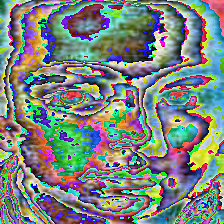

In [ ]:
# transform=Norm
t = transforms.ToPILImage()
print(artf[999][0].size())
t(artf[999][0])

In [ ]:
artfF = Faces(faces_dataset["images"], faces_dataset["label"], transform=Fused)

The following is an example of application of `fused()` function, so with both Gaussian Noise and normalization.

torch.Size([3, 224, 224])


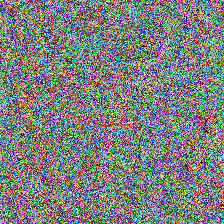

In [ ]:
# transform = fused 
t = transforms.ToPILImage()
print(artfF[999][0].size())
t(artfF[999][0])

We define DataLoaders for training
and testing.
Below we have two sets of dataloaders: the former is built using `Norm() ` tranformation, the latter using `Fused()` instead.


In [ ]:
train_size = int(0.8 * len(faces_dataset))
test_size = len(faces_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(artf, [train_size, test_size])

In [ ]:
train_dl = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size = 8, shuffle=True)


In [ ]:
train_size = int(0.8 * len(faces_dataset))
test_size = len(faces_dataset) - train_size
train_datasetF, test_datasetF = torch.utils.data.random_split(artfF, [train_size, test_size])

In [ ]:
train_dlF = DataLoader(train_datasetF, batch_size = 8, shuffle=True)
test_dlF = DataLoader(test_datasetF, batch_size = 8, shuffle=True)


# Models
For the `Art Faces` dataset we have chosen to use two architectures:
- **GoogleNet**
- **ResNet34**

## Useful functions


### Training 
We define two functions to train and test the networks:`trainer_SGD`, `trainer_Adam`.
The first uses as optimizer the stochastic gradient descent (SGD), the second Adam optimizer. Train loss and train accuracy are printed every ten epochs. 
Both functions validate the model on the test set, after training is completed.

In [ ]:
def trainer_SGD(net, train, test, num_epochs, lr, num_layers_Res=34,
                batch_size = 32, no_classes = 10, sched_step_size=20, sched_gamma=0.1)->list:

                          """This function can be used to train a model. Choose between models and pass the net name 
                          to the function"""
                          
                          metrics = torchmetrics.Accuracy(task="multiclass", num_classes=no_classes).to(device = "cuda")
                
                          if net == "GoogleNet":
                            net = GoogleNet(img_channels = 3, inception = Inception)

                          if net == "ResNet":
                            net = ResNet(num_layers=num_layers_Res, block=Block, image_channels=3, num_classes=no_classes)

                          net.cuda()  
                          loss_values  = []
                          accuracy_tr  = []
                          loss_test    = []
                          optimizer    = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, nesterov=True)
                          scheduler    = torch.optim.lr_scheduler.StepLR(optimizer, step_size=sched_step_size, gamma=sched_gamma)
                          loss         = nn.CrossEntropyLoss()
                          true         = []
                          predicted    = []

                          for i, epoch in enumerate(range(num_epochs)):
                            
                            net.train()
                            batch_loss, acc = 0.0 , 0
                            
                            for (X, y) in train:
                              X = X.cuda()
                              y = y.cuda()
                              optimizer.zero_grad()
                              y_hat = net(X)
                              l = loss(y_hat, y)
                              l.backward()
                              optimizer.step()
                              batch_loss += l.item() * X.size(0)
                              acc += metrics(y_hat,y)

                              
                            acc_batch = acc/len(train)
                            accuracy_tr.append(acc_batch)
                            overall_l = batch_loss/len(train.sampler)
                            loss_values.append(overall_l)
                            
                            if i % 10 == 0:
                              print(f"Train Loss is: {overall_l}","|" ,
                                  f"Train Accuracy is: {acc_batch}", "|")
                              
                            metrics.reset()

                          net.eval()
                          with torch.no_grad():
                            batch_loss_test , acc_test = 0.0 , 0
                            for (X_test, y_test) in test:
                              X_test = X_test.cuda()
                              y_test = y_test.cuda()
                              y_hat_test = net(X_test)
                              l = loss(y_hat_test, y_test)
                              batch_loss_test += l.item() *X_test.size(0)
                              acc_test += metrics(y_hat_test, y_test)
                              true.append(y_test)
                              predicted.append(y_hat_test.argmax(dim = 1))
                            
                              metrics.reset()
                            acc_test_batch=acc_test/len(test)
                            loss_test.append(batch_loss_test/len(test.sampler))
                          
                            
                          return loss_values, accuracy_tr, loss_test, acc_test_batch, true, predicted


In [ ]:
def trainer_Adam(net, train, test, num_epochs, lr, num_layers_Res=34,
                batch_size = 32, no_classes = 10)->list:

                          """This function can be used to train a model. Choose between models and pass the net name 
                          to the function"""
                          
                          metrics = torchmetrics.Accuracy(task="multiclass", num_classes=no_classes).to(device = "cuda")

                          if net == "GoogleNet":
                            net = GoogleNet(img_channels=3, inception = Inception)

                          if net == "ResNet":
                            net = ResNet(num_layers=num_layers_Res, block=Block, image_channels=3, num_classes=no_classes)

                          net.cuda()  
                          loss_values  = []
                          accuracy_tr  = []
                          loss_test    = []
                          optimizer    = torch.optim.Adam(net.parameters(), lr=lr)
                          loss         = nn.CrossEntropyLoss()
                          true         = []
                          predicted    = []

                          
                          for i, epoch in enumerate(range(num_epochs)):
                            
                            net.train()
                            batch_loss, acc = 0.0 ,0
                            
                            for (X, y) in train:
                              X = X.cuda()
                              y = y.cuda()
                              optimizer.zero_grad()
                              y_hat = net(X)
                              l = loss(y_hat, y)
                              l.backward()
                              optimizer.step()
                              batch_loss += l.item() * X.size(0)
                              acc += metrics(y_hat, y)
                              
                            overall_l = batch_loss/len(train.sampler)
                            acc_batch = acc/len(train)
                            accuracy_tr.append(acc_batch)
                            loss_values.append(overall_l)

                            if i % 10 == 0:
                              print(f"Train Loss is: {overall_l}","|" ,
                                  f"Train Accuracy is: {acc_batch}", "|")
                              
                            metrics.reset()

                          net.eval()
                          with torch.no_grad():
                            batch_loss_test , acc_test = 0.0 , 0
                            for (X_test, y_test) in test:
                              X_test = X_test.cuda()
                              y_test = y_test.cuda()
                              y_hat_test = net(X_test)
                              l = loss(y_hat_test, y_test)
                              batch_loss_test += l.item() *X_test.size(0)
                              acc_test += metrics(y_hat_test, y_test)
                              true.append(y_test)
                              predicted.append(y_hat_test.argmax(dim = 1))
                              metrics.reset()
                            
                            loss_test.append(batch_loss_test/len(test.sampler))
                            acc_test_batch = acc_test/len(test)
                          
                            
                          return loss_values, accuracy_tr, loss_test, acc_test_batch, true, predicted


### Plotting

The following code implements the `plotting` function to plot Train loss and Train accuracy among the epochs.

In [ ]:
def plotting(loss_values, precision_tr, net):
  tr_acc_resnet2=[]
  for i in precision_tr:
    tr_acc_resnet2.append(i.item())
  fig = go.Figure(data=go.Scatter(x=np.arange(len(loss_values)), y=loss_values , name='Train Loss'))
  fig.add_scatter(x=np.arange(len(tr_acc_resnet2 )), y=tr_acc_resnet2 , line=dict(color="orange", width=2),mode = "lines" , name='Train accuracy')
  fig.update_layout(title="Train loss and Train accuracy - " + net)
  fig.show()

We define two function to plot the Confusion Matrix for the test set. 
The confusion matrix allows us to visualize the performance of the models. 
Each row of the matrix rapresents the actual labels, whereas on each column there are predicted labels. 
- `confusion_matrix()` : plots the confusion matrix.
- `confusion_matrix2()` : plots the confusion matrix with accuracy values for each label on the main diagonal.

In [ ]:
art_genres = [ 'art-noveau', 'baroque', 'expressionism', 'high-renaissance', 'impressionism', 'mannerism', 'realism', 'rococo', 'romanticism', 'symbolism']

In [ ]:
def confusion_matrix(predicted, true, batch_size , net , labels):
  pred = []
  
  for i in predicted:
    if len(i)==batch_size:
      pred.append(i.tolist())

  t = []
  for j in true:     
    if len(j)==batch_size:
      t.append(j.tolist()) 

  ConfMatr = CM(task="multiclass", num_classes=10) # ConfusionMatrix imported as CM
  cm       = ConfMatr(torch.Tensor(pred), torch.Tensor(t))
  cm       = cm.tolist()
  df_cm    = pd.DataFrame(cm, columns=labels, index=labels)
  fig, ax = plt.subplots(figsize=(10,5)) 
  sns.heatmap(df_cm, annot=True)
  plt.title('Confusion Matrix'+net, fontsize = 20) # title with fontsize 20
  plt.ylabel('True', fontsize = 15) # x-axis label with fontsize 15
  plt.xlabel('Predicted', fontsize = 15) # y-axis label with fontsize 15
  plt.show()

In [ ]:
def confusion_matrix2(predicted, true, batch_size , net , labels):
  pred = []
  
  for i in predicted:
    if len(i)==batch_size:
      pred.append(i.tolist())

  t = []
  for j in true:     
    if len(j)==batch_size:
      t.append(j.tolist()) 

  ConfMatr = CM(task="multiclass", num_classes=10) # ConfusionMatrix imported as CM
  cm       = ConfMatr(torch.Tensor(pred), torch.Tensor(t))
  cm=cm/torch.sum(cm , dim=0)
  cm       = cm.tolist()
  df_cm    = pd.DataFrame(cm, columns=labels, index=labels)

  fig, ax = plt.subplots(figsize=(10,5)) 
  sns.heatmap(df_cm, annot=True)
  plt.title('Confusion Matrix'+net, fontsize = 20) # title with fontsize 20
  plt.ylabel('True', fontsize = 15) # x-axis label with fontsize 15
  plt.xlabel('Predicted', fontsize = 15) # y-axis label with fontsize 15
  plt.show()

To better investigate the model performance we define `print_class_report` to show precision, recall and F1 score for all the different artistic genres.


In [ ]:
def print_class_report(trues, predictions, batch_size, labels):
  tr = [None] * batch_size * len(trues)
  pr = [None] * batch_size * len(predictions)
  a = 0 
  for i, j in zip(trues, predictions):
    for k in range(len(i)):
      i = list(i)
      j = list(j)
      tr[a] = i[k].item()
      pr[a] = j[k].item()
      a += 1
  
  tr = torch.Tensor(tr)
  pr = torch.Tensor(pr)
  print(classification_report(tr, pr, target_names = labels))


# GoogleNet

GoogLeNet is a 22-layer deep convolutional neural network, some layers are part of the 9 inception blocks that characterize this architecture. The output of an inception block is the concatenation of the outputs of 7 layers executed in four parallel path.

The layers belonging to the inception block are the following:
-	Input layer
-	1x1 convolution layer
-	3x3 convolution layer
-	5x5 convolution layer
-	Max pooling layer
-	Concatenation layer

Before the nine inception blocks there are 2 modules of convolutional layers. The last inception block ends with an average pooling layer that takes a mean across the features map produced by the module. We end up with a reduced input height and width of $1x1$.


### The architecture

In [ ]:
class Inception(nn.Module):
   
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): 
        super(Inception, self).__init__(**kwargs)
        self.relu = nn.ReLU()
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = self.relu(self.p1_1(x))
        p2 = self.relu(self.p2_2(self.relu(self.p2_1(x))))
        p3 = self.relu(self.p3_2(self.relu(self.p3_1(x))))
        p4 = self.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
class GoogleNet(nn.Module):

  def __init__(self, img_channels, inception):
    super(GoogleNet, self).__init__()
    self.img_channels = 3

    self.conv1        = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    self.conv2        = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                                      nn.ReLU(),
                                      nn.Conv2d(64, 192, kernel_size=3, padding=1),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    self.bn           = nn.BatchNorm2d(192) #modifica per speed up 
    #this block uses the Inception 
    self.block3       = nn.Sequential(inception(192, 64, (96, 128), (16, 32), 32),
                                      inception(256, 128, (128, 192), (32, 96), 64),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    self.block4       = nn.Sequential(inception(480, 192, (96, 208), (16, 48), 64),
                                      inception(512, 160, (112, 224), (24, 64), 64),
                                      inception(512, 128, (128, 256), (24, 64), 64),
                                      inception(512, 112, (144, 288), (32, 64), 64),
                                      inception(528, 256, (160, 320), (32, 128), 128),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    self.block5       = nn.Sequential(inception(832, 256, (160, 320), (32, 128), 128),
                                      inception(832, 384, (192, 384), (48, 128), 128),
                                      nn.AdaptiveAvgPool2d((1,1)), # The argument (1,1) is the required OUTPUT shape
                                      nn.Flatten())
    self.linear      = nn.Linear(1024, 10)



  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.bn(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.linear(x)
    return x

    
    

### Normalization of images

#### Training

In [ ]:
tr_l_gn, tr_acc_gn, ts_l_gn, ts_acc_gn, tr_gn, pred_gn = trainer_Adam("GoogleNet", train_dl, test_dl, 80, 0.0002, batch_size=8) #senza batchnorm

Train Loss is: 2.2895524106025698 | Train Accuracy is: 0.11950000375509262 |
Train Loss is: 1.9421359286308288 | Train Accuracy is: 0.2565000057220459 |
Train Loss is: 1.6554969799518586 | Train Accuracy is: 0.3680000305175781 |
Train Loss is: 1.2276230747699737 | Train Accuracy is: 0.5347500443458557 |
Train Loss is: 0.7144038043320179 | Train Accuracy is: 0.7385000586509705 |
Train Loss is: 0.4356108337417245 | Train Accuracy is: 0.8437500596046448 |
Train Loss is: 0.31162298329081384 | Train Accuracy is: 0.8887500166893005 |
Train Loss is: 0.21263816863670945 | Train Accuracy is: 0.9297500252723694 |


#### Results

We check whether train loss has decreased and train accuracy has increased among the epochs. 

In [ ]:
plotting(tr_l_gn, tr_acc_gn, "GoogleNet")

The graph shows the loss descent and the increase of the accuracy. This confirms the weigths are updated so that the predicted labels get closer to the true ones.

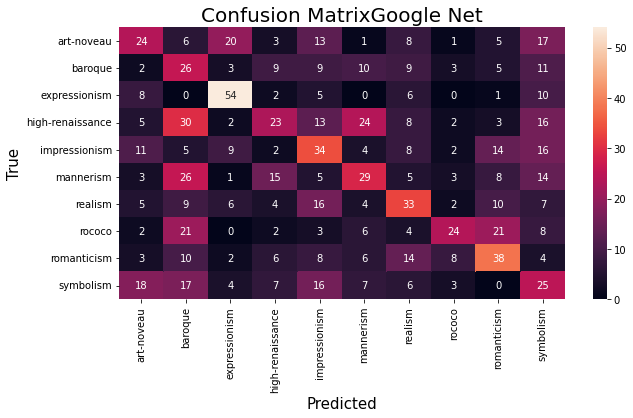

In [ ]:
confusion_matrix(pred_gn, tr_gn, batch_size=8 , net='Google Net' , labels=art_genres)

The concentration of high values on the diagonal of the confusion matrix suggests that the model predicts quite well the style of portraits.
However the model predicts as symobolism many portraits that do not belong to it. In addition the mannieristic and high-reinassance portraits are wrongly predicted as baroque. 


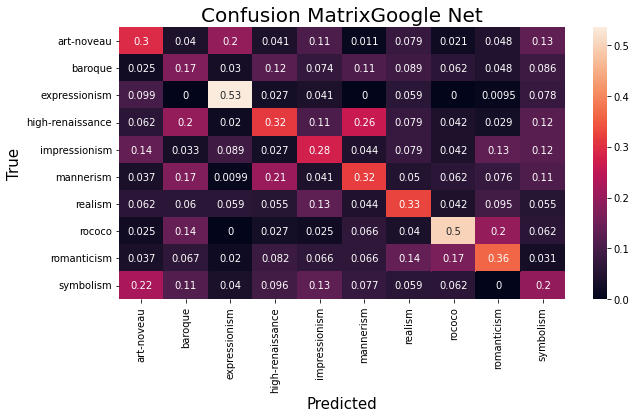

In [ ]:
confusion_matrix2(pred_gn, tr_gn, batch_size=8 , net='Google Net' , labels=art_genres)

In [ ]:
print_class_report(trues=tr_gn, predictions=pred_gn, batch_size=8, labels=art_genres)

                  precision    recall  f1-score   support

      art-noveau       0.30      0.24      0.27        98
         baroque       0.17      0.30      0.22        87
   expressionism       0.53      0.63      0.58        86
high-renaissance       0.32      0.18      0.23       126
   impressionism       0.28      0.32      0.30       105
       mannerism       0.32      0.27      0.29       109
         realism       0.33      0.34      0.34        96
          rococo       0.50      0.26      0.35        91
     romanticism       0.36      0.38      0.37        99
       symbolism       0.20      0.24      0.22       103

        accuracy                           0.31      1000
       macro avg       0.33      0.32      0.32      1000
    weighted avg       0.33      0.31      0.31      1000



The classification report shows that the model performs very well in predicting expressionism and rococo style. This is something reasonable since the expressionism is a very revolutionary style, easily recognizable.
- **Precision**: out of all the portraits the model labelled as expressionism $53\%$ of those that actually belong to that category  
- **Recall**: out of all the portraits that actually belong to the expressionism artistic genre $63\%$ were labelled as such by the model.
- **F1 Score**: being an armonic mean of precision and recall it summarizes the two previous statistics.

### Fused transformation on images

We start by training GoogLeNet on images after having applied the `Fused` transformation (Normalization and gaussian noise).

#### Training

In [ ]:
tr_l_gnF, tr_acc_gnF, ts_l_gnF, ts_acc_gnF, tr_gnF, pred_gnF = trainer_Adam("GoogleNet", train_dlF, test_dlF, 80, 0.0002, batch_size=8) #senza batchnorm

Train Loss is: 2.302169550895691 | Train Accuracy is: 0.25 |
Train Loss is: 1.9547234437465668 | Train Accuracy is: 0.25 |
Train Loss is: 1.7226393299102782 | Train Accuracy is: 0.25 |
Train Loss is: 1.264242573618889 | Train Accuracy is: 0.5 |
Train Loss is: 0.7245914541333914 | Train Accuracy is: 0.625 |
Train Loss is: 0.3647891540080309 | Train Accuracy is: 1.0 |
Train Loss is: 0.3147915502488613 | Train Accuracy is: 1.0 |
Train Loss is: 0.20196610766917 | Train Accuracy is: 1.0 |


#### Results

Now we visualize the training loss and accuracy.

In [ ]:
plotting(tr_l_gnF, tr_acc_gnF, "GoogleNet (Gaussian Noise)")

We see no substantial differences with respect to before.

In [ ]:
print_class_report(trues=tr_gnF, predictions=pred_gnF, batch_size=8, labels=art_genres)

                  precision    recall  f1-score   support

      art-noveau       0.39      0.27      0.32       114
         baroque       0.28      0.27      0.27       104
   expressionism       0.60      0.50      0.54       112
high-renaissance       0.24      0.31      0.27        99
   impressionism       0.28      0.32      0.30        87
       mannerism       0.30      0.26      0.28       110
         realism       0.23      0.26      0.24        90
          rococo       0.43      0.59      0.49        97
     romanticism       0.42      0.27      0.33        97
       symbolism       0.20      0.23      0.22        90

        accuracy                           0.33      1000
       macro avg       0.34      0.33      0.33      1000
    weighted avg       0.34      0.33      0.33      1000



Also for what concerns the classification report we see no substantial differences with respect to the Normalized images. We can just highlight that expressionism precision is a bit higher in this case. It seems that by adding Gaussian Noise our model learns a little better. This result is also confirmed by looking at the confusion matrix.

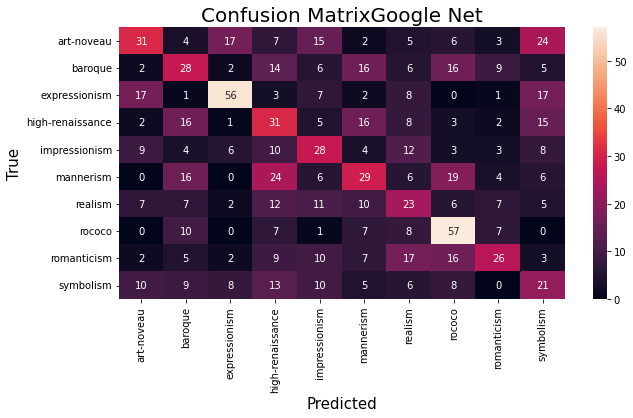

In [ ]:
confusion_matrix(pred_gnF, tr_gnF, batch_size=8 , net='Google Net' , labels=art_genres)

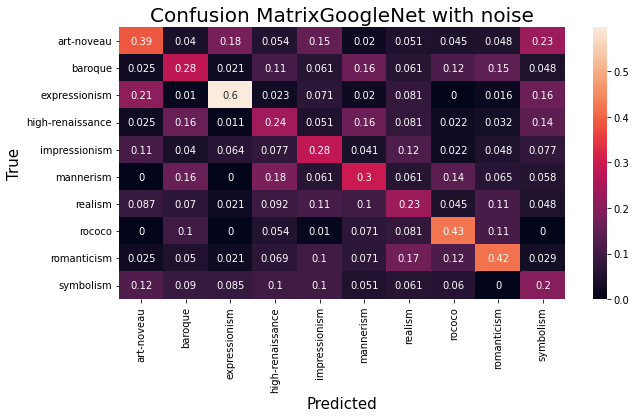

In [ ]:
confusion_matrix2(predicted=pred_gnF, true=tr_gnF, batch_size=8, net='GoogleNet with noise' , labels=art_genres)

# RESNET

We have decided to use ResNet architecture. ResNet was introduced in  the paper [of  Kaiming He et al](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), in order to deal with the vanishing gradient problem, an issue that occurs when the network has a very deep structure. Although ResNet has a very deep architecture (allowing for a number of convolutional layers ranging from 18 to 152) it does not suffer from the vanishing gradient problem. This is possible thanks to the residual connections, through which the gradient flows directly backwards from deep layers to initial filters.
The following code implements ResNet architecture. Firstly we define the class Block, that allows to perform the residual connection when needed. The class ResNet completely specifies the architecture, by calling and using the Block class when a residual connection is needed.

## The architecture

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        
        super(Block, self).__init__()

        self.num_layers   = num_layers
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        
        super(ResNet, self).__init__()
        
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 :
            layers = [3, 4, 6, 3]
        
        self.in_channels = 64
        self.conv1       = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1         = nn.BatchNorm2d(64)
        self.relu        = nn.ReLU()
        self.maxpool     = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels,
                                                      kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels 
        for i in range(num_residual_blocks - 1):

            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
            
        return nn.Sequential(*layers)


## Training RESNET

In [ ]:
tr_l_resnet, tr_acc_resnet, ts_l_resnet, ts_acc_resnet, tr_resnet, pred_resnet = trainer_SGD("ResNet", train_dl, test_dl, 60, 0.02, 18 , batch_size = 8)


Train Loss is: 2.309175325870514 | Train Accuracy is: 0.14900000393390656 |
Train Loss is: 1.7947523379325867 | Train Accuracy is: 0.34425002336502075 |
Train Loss is: 1.104362600028515 | Train Accuracy is: 0.6077500581741333 |
Train Loss is: 0.28090548840444535 | Train Accuracy is: 0.906000018119812 |
Train Loss is: 0.08003583923517726 | Train Accuracy is: 0.9767500758171082 |
Train Loss is: 0.04227096651191096 | Train Accuracy is: 0.9890000224113464 |


## Results

In [ ]:
plotting(tr_l_resnet, tr_acc_resnet, "Resnet18")

With respect to GoogLeNet loss decreases faster. We could have stopped to train our model even at the 40th epoch. The acccuracy goes quite quickly to one.

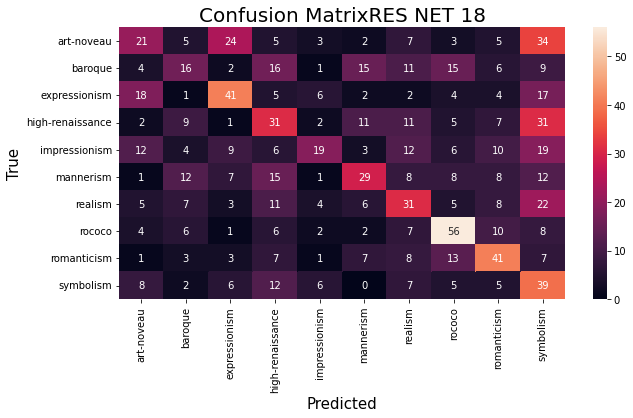

In [ ]:
confusion_matrix(pred_resnet, tr_resnet, batch_size=8 , net="RES NET 18", labels=art_genres)

From the confusion matrix we can see that our model wrongly predicts belongingness to symbolism even for portraits of other style. This also happens sligthly in high-reinassance.

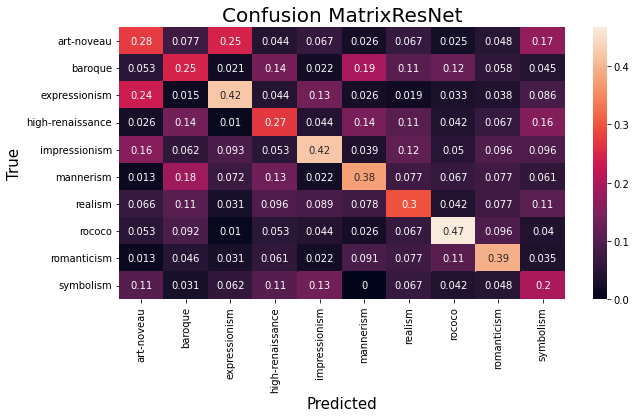

In [ ]:
confusion_matrix2(pred_resnet, tr_resnet, batch_size=8 , net='ResNet' , labels=art_genres)

In [ ]:
print_class_report(trues=tr_resnet, predictions=pred_resnet, batch_size=8, labels=art_genres)

                  precision    recall  f1-score   support

      art-noveau       0.28      0.19      0.23       109
         baroque       0.25      0.17      0.20        95
   expressionism       0.42      0.41      0.42       100
high-renaissance       0.27      0.28      0.28       110
   impressionism       0.42      0.19      0.26       100
       mannerism       0.38      0.29      0.33       101
         realism       0.30      0.30      0.30       102
          rococo       0.47      0.55      0.50       102
     romanticism       0.39      0.45      0.42        91
       symbolism       0.20      0.43      0.27        90

        accuracy                           0.32      1000
       macro avg       0.34      0.33      0.32      1000
    weighted avg       0.34      0.32      0.32      1000



In classification report we notice that highest precision and recall is achived by rococo. 

## K-fold cross validation
To check the performance of our model we decided to implement a **K-fold cross validation**. At first, we have divided the dataset in training  and test. The K-fold will be implemented only on the training subset, that will be divided in k consecutive folds. The model will be trained on all the folds except one, that will be considered as validation set. This operation is performed for each fold and each time the weigths are updated. At the end we will check the performance on the test set left apart at the beginning. This final step is for an additional confirmation.


The code below is the implementation of the K-fold cross validation. With the for cycle we take k times the indexes of the validation and of the training subset. Each time we define the data loader of validation and train and for `num_epoch` we compute loss and accuracy for both training and validation set.

### Validation and test set

In [ ]:
train_valid_size = int(0.8 * len(faces_dataset))         # use 80% of our data to perform LOOOCV
test_size        = len(faces_dataset) - train_valid_size # keep out the 20% in order to have a better idea of the performances of our model 
# on complitely unseen data


In [132]:
train_valid_set, test_set  = torch.utils.data.random_split(artfF, [train_valid_size, test_size])

### Useful functions

We define below two funcitons one for training (`train_epoch`) and another for validation (`valid_epoch`).

In [133]:
def train_epoch(dataloader, loss_fn, net):

  train_loss, train_acc = 0.0,0
  metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")
  net.train() 
  
  for (X, y) in dataloader:
    X = X.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    y_hat = net(X)
    l = loss_fn(y_hat, y)
    l.backward()
    optimizer.step()
    train_loss += l.item() * X.size(0)
    train_acc  += metrics(y_hat, y)
    metrics.reset()

  acc_batch = train_acc / len(dataloader)

  return train_loss, acc_batch


def valid_epoch(dataloader ,loss_fn, net):
    
    valid_loss, valid_acc =0.0, 0
    metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")
    net.eval()

    for (X, y) in dataloader:
      X           = X.cuda()
      y           = y.cuda()
      y_hat       = net(X)
      l           = loss_fn(y_hat, y)
      valid_loss += l.item() * X.size(0)
      valid_acc  += metrics(y_hat, y)
      metrics.reset()

    acc_batch = valid_acc / len(dataloader)

    return valid_loss , acc_batch

Follows the definition of three functions to rapresent and summarize the performance of the K-Fold cross validation.

In [136]:
def performance_kfold(tr_l, tr_acc, valid_l, valid_acc):
  tr_loss2=[]
  for i in tr_l:
    tr_loss2.append(i)
  tr_acc2 = []
  for i in tr_acc:
    tr_acc2.append(i.item())
  valid_acc2 = []
  for i in valid_acc:
    valid_acc2.append(i.item())

  avg_train_loss = np.mean(np.asarray(tr_loss2))
  avg_test_loss = np.mean(np.asarray(valid_l))
  avg_train_acc = np.mean(np.asarray(tr_acc2))
  avg_test_acc = np.mean(np.asarray(valid_acc2))

  print('Performance of {} fold cross validation'.format(k))
  print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))

  


In [138]:
def loss_Kfold(train_l, valid_l, net):
  tr_loss2=[]
  for i in history['train_loss']:
    tr_loss2.append(i)
  fig = go.Figure(data=go.Scatter(x=np.arange(len(tr_loss2)), y=tr_loss2, name='Train Loss'))
  fig.add_scatter(x=np.arange(len(valid_l)), y = valid_l, line=dict(color="orange", width=2),mode = "lines" , name='Validation Loss')
  fig.update_layout(title="Train loss and Validation loss | K-fold cross validation - " + net)
  fig.show()

In [140]:
def acc_Kfold(train_acc, valid_acc, net):
  tr_acc2 = []
  for i in train_acc:
    tr_acc2.append(i.item())

  valid_acc2 = []
  for i in valid_acc:
    valid_acc2.append(i.item())
  
  fig = go.Figure(data=go.Scatter(x=np.arange(len(tr_acc2)), y=tr_acc2, name='Train Accuracy'))
  fig.add_scatter(x=np.arange(len(valid_acc2)), y = valid_acc2, line=dict(color="orange", width=2),mode = "lines" , name='Validation Accuracy')
  fig.update_layout(title="Train accuracy and Validation accuracy | K-fold cross validation - " + net)
  fig.show()

We define a funciton `test` to test the model on the remaining $10\%$ of our data, in this way we can check how RESNET performs on completely unseen data.

In [129]:
def test(loss_fn, net, batch_size):
    
    dataloader = DataLoader(test_set, batch_size = batch_size)
    test_loss = 0.0
    metrics = torchmetrics.Accuracy("multiclass", num_classes=10).to(device="cuda")

    net.eval()
    for (X, y) in dataloader:

      X     = X.cuda()
      y     = y.cuda()
      y_hat = net(X)
      l     = loss_fn(y_hat, y)

      test_loss+= l.item() * X.size(0)
      true = y
      pred = net(X)
      test_acc = metrics(y_hat, y)
      metrics.reset()

    return test_loss/len(dataloader.sampler) , test_acc

### Training

In [134]:
num_epochs = 5
batch_size = 8
k          = 10
splitter   = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}


In [135]:
history    = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}


net        = ResNet(18, Block, 3, 10)
net.cuda()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.002)

for fold, (train_idx, val_idx) in enumerate(splitter.split(np.arange(train_valid_size))):
  
  print('Fold {}'.format(fold + 1))

  train_sampler  = SubsetRandomSampler(train_idx)
  valid_sampler  = SubsetRandomSampler(val_idx)
  train_loader   = DataLoader(train_valid_set, batch_size = batch_size, sampler = train_sampler)
  valid_loader   = DataLoader(train_valid_set, batch_size = batch_size, sampler = valid_sampler)

    

  for epoch in range(num_epochs):
    
    train_loss, train_acc = train_epoch(train_loader, nn.CrossEntropyLoss(), net)
    valid_loss, valid_acc = valid_epoch(valid_loader, nn.CrossEntropyLoss(), net)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_acc  = train_acc * 100
    valid_acc  = valid_acc * 100
      
    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             valid_loss,
                                                                                                             train_acc,
                                                                                                             valid_acc))
        
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc) 

Fold 1
Epoch:1/5 AVG Training Loss:2.280 AVG Test Loss:2.222 AVG Training Acc 15.28 % AVG Test Acc 15.75 %
Epoch:2/5 AVG Training Loss:2.157 AVG Test Loss:2.315 AVG Training Acc 19.89 % AVG Test Acc 15.25 %
Epoch:3/5 AVG Training Loss:2.138 AVG Test Loss:2.077 AVG Training Acc 20.83 % AVG Test Acc 23.25 %
Epoch:4/5 AVG Training Loss:2.104 AVG Test Loss:2.036 AVG Training Acc 21.64 % AVG Test Acc 21.50 %
Epoch:5/5 AVG Training Loss:2.068 AVG Test Loss:2.028 AVG Training Acc 22.44 % AVG Test Acc 26.25 %
Fold 2
Epoch:1/5 AVG Training Loss:2.043 AVG Test Loss:1.985 AVG Training Acc 23.36 % AVG Test Acc 25.50 %
Epoch:2/5 AVG Training Loss:2.025 AVG Test Loss:2.004 AVG Training Acc 24.42 % AVG Test Acc 25.00 %
Epoch:3/5 AVG Training Loss:1.991 AVG Test Loss:1.977 AVG Training Acc 26.92 % AVG Test Acc 27.00 %
Epoch:4/5 AVG Training Loss:1.964 AVG Test Loss:1.914 AVG Training Acc 28.67 % AVG Test Acc 28.75 %
Epoch:5/5 AVG Training Loss:1.919 AVG Test Loss:1.947 AVG Training Acc 30.50 % AVG Tes

### Results

In [137]:
performance_kfold(history['train_loss'], history['train_acc'], history['valid_loss'], history['valid_acc'])

Performance of 10 fold cross validation
Average Training Loss: 0.9653 	 Average Test Loss: 0.9971 	 Average Training Acc: 65.415 	 Average Test Acc: 64.265


We are very satisfied of the overall performance of this model on the validation set.

In [139]:
loss_Kfold(history['train_loss'], history['valid_loss'], "ResNet")

We observe the decrease of both training and validation loss and the increasing behaviour of training and validation accuracy.

In [141]:
acc_Kfold(history['train_acc'], history['valid_acc'], "ResNet")

We now validate our model on unseen data (test set).



In [143]:
test(nn.CrossEntropyLoss(), net , 8)

(3.6958312101364137, tensor(0.3750, device='cuda:0'))

We end up with a test accuracy of $37.50\%$. Although not being such an high accuracy it is still better than randomly assign labels.

# Conclusions
We first tried with the GoogleNet architecture and the result were quite satisfying.
However we decided to implement another popular architecture to have a comparison term. We get similar results and this validate our work.
